# Attribute Importance for Concept Drift - Analysis on the BPI challenge 2015 dataset

The process drift explanation framework is applied on the permit application process of five Dutch municipalities.

## Setup
### Imports

In [1]:
# imports
import helper
import math
import pm4py
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import population_comparison
from processdrift.framework import windowing
from processdrift.framework import change_point_extraction

### Data settings and event log loading

In [2]:
# specify the file paths for each municipal's log
file_paths = {'mun_1': 'data/real/bpic_2015/BPIC15_1.xes',
                    'mun_2': 'data/real/bpic_2015/BPIC15_2.xes',
                    'mun_3': 'data/real/bpic_2015/BPIC15_3.xes',
                    'mun_4': 'data/real/bpic_2015/BPIC15_4.xes',
                    'mun_5': 'data/real/bpic_2015/BPIC15_5.xes'}
muns = file_paths.keys()

In [3]:
# load the event logs
event_logs = {mun: xes_importer.apply(file_path) for mun, file_path in file_paths.items()}

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1156/1156 [00:07<00:00, 164.58it/s]


## Present basic analysis

In [4]:
def get_basic_stats(event_log, get_attribute_values=False):
    # get some basic statistics (number of events, number of traces, attributes...)
    basic_stats = {}

    # event statistics
    event_stream = pm4py.convert.convert_to_event_stream(event_log)
    number_events = len(event_stream)
    basic_stats['Number of events'] = number_events

    event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)

    if get_attribute_values:
        basic_stats['Event attributes'] = str(sorted(event_attributes))

    number_event_attributes = len(event_attributes)
    basic_stats['Number event attributes'] = number_event_attributes

    # trace statistics
    number_traces = len(event_log)
    basic_stats['Number traces'] = number_traces

    trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
    if get_attribute_values:
        basic_stats['Trace attributes'] = str(sorted(trace_attributes))

    number_trace_attributes = len(trace_attributes)
    basic_stats['Number trace attributes'] = number_trace_attributes

    basic_stats_series = pd.Series(basic_stats)
    return basic_stats_series

In [5]:
basic_stats_individual_logs = {mun: get_basic_stats(event_log) for mun, event_log in event_logs.items()}
all_stats = pd.concat(basic_stats_individual_logs.values(), axis=1)
all_stats.columns = basic_stats_individual_logs.keys()
all_stats

,mun_1,mun_2,mun_3,mun_4,mun_5
Number of events,52217,44354,59681,47293,59083
Number event attributes,12,12,12,12,12
Number traces,1199,832,1409,1053,1156
Number trace attributes,15,14,15,15,15


In [6]:
# check if all logs have the same event and trace attributes
event_attributes_per_mun = {mun: pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log) for mun, event_log in event_logs.items()}
trace_attributes_per_mun = {mun: pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log) for mun, event_log in event_logs.items()}
all_event_attributes = set().union(*event_attributes_per_mun.values())
all_trace_attributes = set().union(*trace_attributes_per_mun.values())

In [8]:
# build a dictionary that hold the attributes and for which munincipality they apply
# this can be put into a table
attributes_dict = {}
for event_attribute in all_event_attributes:
    truth_array = []
    for mun in muns:
        if event_attribute in event_attributes_per_mun[mun]:
            truth_array.append(True)
        else:
            truth_array.append(False)
    attributes_dict[f'event: {event_attribute}'] = truth_array

for trace_attribute in all_trace_attributes:
    truth_array = []
    for mun in muns:
        if trace_attribute in trace_attributes_per_mun[mun]:
            truth_array.append(True)
        else:
            truth_array.append(False)
    attributes_dict[f'trace: {trace_attribute}'] = truth_array

In [9]:
pd.DataFrame().from_dict(attributes_dict, orient='index', columns=muns)

,mun_1,mun_2,mun_3,mun_4,mun_5
event: planned,True,True,True,True,True
event: dateFinished,True,True,True,True,True
event: action_code,True,True,True,True,True
event: time:timestamp,True,True,True,True,True
event: monitoringResource,True,True,True,True,True
event: dateStop,True,True,True,True,True
event: activityNameNL,True,True,True,True,True
event: dueDate,True,True,True,True,True
event: question,True,True,True,True,True
event: activityNameEN,True,True,True,True,True


All event attributes are the same. One municipal is missing the `endDatePlanned` attribute. This is municipal 2, as can be seen in the attribute value count of this municipal.

Now, get an impression on the values which the attributes hold. For that, municipal 1 is selected.

In [10]:
example_mun = 'mun_1'
trace_attributes = trace_attributes_per_mun[example_mun]
event_attributes = event_attributes_per_mun[example_mun]

display(helper.get_examples_of_event_attributes(event_logs[example_mun], 10, event_attributes))

,monitoringResource,org:resource,activityNameNL,concept:name,question,dateFinished,action_code,activityNameEN,planned,time:timestamp
0,2670601,560872,OLO berichtenverkeer actief,01_HOOFD_011,False,2013-04-08 09:32:52,01_HOOFD_011,OLO messaging active,2013-04-09 09:32:45+02:00,2013-04-08 09:32:47+02:00
1,4676453,560872,instellen besluitfase: oorspronkelijk besluit,01_BB_770,EMPTY,2012-10-11 16:18:00,01_BB_770,set phase: phase permitting irrevocable,2012-10-12 16:15:42+02:00,2012-10-11 16:15:41+02:00
2,2670601,9264148,fase aanvraag ontvangen,01_HOOFD_015,EMPTY,2014-10-02 00:00:00,01_HOOFD_015,phase application received,2014-10-03 14:22:55+02:00,2014-10-02 00:00:00+02:00
3,560872,560872,aanhoudingsgrond van toepassing,01_HOOFD_470,False,2011-08-29 10:13:00,01_HOOFD_470,suspension ground applicable,2011-08-30 10:08:25+02:00,2011-08-29 10:08:29+02:00
4,4676959,560872,stop alle lopende deelzaken 2b,01_HOOFD_811,EMPTY,2013-10-25 00:00:00,01_HOOFD_811,stop all running subcases 2b,2013-10-26 11:22:46+02:00,2013-10-25 00:00:00+02:00
5,560890,560890,registreren datum besluit omgevingsvergunning2,01_HOOFD_490_5,EMPTY,2013-06-07 00:00:00,01_HOOFD_490_5,record date of decision environmental permit,2013-06-07 11:43:20+02:00,2013-06-07 00:00:00+02:00
6,3273854,560912,procedurebevestiging versturen,01_HOOFD_065_1,EMPTY,2012-05-21 14:33:51,01_HOOFD_065_1,send procedure confirmation,2012-05-22 14:32:59+02:00,2012-05-21 14:33:00+02:00
7,560872,2670601,aanvraag volledig,01_HOOFD_200,True,2011-05-03 10:51:19,01_HOOFD_200,request complete,2011-03-24 17:00:38+01:00,2011-05-03 09:44:20+02:00
8,560925,560872,invoeren verzenddatum procedurebevestiging,01_HOOFD_190_2,EMPTY,2010-11-29 11:47:23,01_HOOFD_190_2,enter senddate procedure confirmation,NaN,2010-11-30 00:00:00+01:00
9,3273854,560890,genereren beschikking omgevingsvergunning,01_HOOFD_490_4,EMPTY,2012-08-21 17:01:40,01_HOOFD_490_4,generating decision environmental permit,2012-08-22 14:00:09+02:00,2012-08-21 17:01:17+02:00


The events fields 'activityNameNL', 'concept:name', 'action_code' and 'activityNameEN' all contain the same information: different representations of the activity that was executed in an event.

The timestamps should also be deleted from the feature analysis. They would always be significantly different as they are expected to increase over time.

In [11]:
selected_event_attributes = ['monitoringResource', 'org:resource', 'question']
selected_event_attributes

['monitoringResource', 'org:resource', 'question']

In [12]:
display(helper.get_examples_of_trace_attributes(event_logs[example_mun], 10, trace_attributes))

,endDate,caseStatus,SUMleges,last_phase,case_type,Includes_subCases,Responsible_actor,landRegisterID,parts,termName,startDate,requestComplete,IDofConceptCase,caseProcedure
0,2012-11-20 00:00:00+01:00,O,3523.06570,Beschikking verzonden,557669,J,560464,5225055,Bouw,Termijn bezwaar en beroep 1,2012-10-17 00:00:00+02:00,TRUE,5991172,NaN
1,NaN,O,553.00800,Proceduretermijn opgeschort,557669,J,4936828,NaN,"Bouw,Gebiedsbescherming,Milieu (vergunning)",Termijn aanvullende gegevens,2011-06-30 00:00:00+02:00,FALSE,NaN,Uitgebreid
2,2013-09-06 00:00:00+02:00,G,213.61620,Zaak afgehandeld,557669,N,4901428,NaN,Kap,NaN,2013-07-17 00:00:00+02:00,TRUE,NaN,NaN
3,NaN,O,682.37476,Beschikking verzonden,557669,NaN,560912,NaN,"Bouw,Milieu (neutraal wijziging),Milieu (omgev...",Termijn bezwaar en beroep 1,2014-11-24 00:00:00+01:00,TRUE,12181438,NaN
4,2013-04-26 00:00:00+02:00,O,568.62036,Beschikking verzonden,557669,J,560464,6934896,"Bouw,Handelen in strijd met regels RO",Termijn bezwaar en beroep 1,2013-03-06 00:00:00+01:00,TRUE,6935038,NaN
5,NaN,G,NaN,Aangepast plan gevraagd,557669,J,560950,NaN,Milieu (vergunning),Termijn tot besluit,2012-09-18 00:00:00+02:00,TRUE,5878847,NaN
6,2011-10-19 00:00:00+02:00,G,NaN,Vergunning verleend,557669,N,560872,719982,Kap,NaN,2011-07-29 00:00:00+02:00,TRUE,NaN,NaN
7,2012-03-05 00:00:00+01:00,O,10288.31000,Vergunning verleend,557669,J,560464,NaN,Bouw,Termijn bezwaar en beroep 1,2012-01-13 00:00:00+01:00,TRUE,NaN,NaN
8,2012-06-04 00:00:00+02:00,G,NaN,Procedure afgebroken,557669,N,560872,NaN,Bouw,NaN,2012-05-30 00:00:00+02:00,TRUE,5088217,NaN
9,2012-06-19 00:00:00+02:00,G,306.51480,Besluit genomen,557669,J,4901428,NaN,Bouw,Termijn bezwaar en beroep 1,2012-04-27 00:00:00+02:00,TRUE,4960669,NaN


Also for the trace attributes, the date fields should not be analyzed for drift. This gets rid of the `endDatePlanned` attribute that is not available for all municipal logs.

Also the fields 'IDofConceptCase' and 'landRegisterID' are excluded from the analysis as they are holding identifying numbers.

In [13]:
selected_trace_attributes = ['caseStatus', 'SUMleges', 'last_phase', 'case_type', 'Includes_subCases', 'Responsible_actor', 'parts', 'termName', 'requestComplete', 'caseProcedure']
selected_trace_attributes

['caseStatus',
 'SUMleges',
 'last_phase',
 'case_type',
 'Includes_subCases',
 'Responsible_actor',
 'parts',
 'termName',
 'requestComplete',
 'caseProcedure']

In [14]:
attribute_level_type_list = helper.automatically_get_attributes_and_data_types(event_logs[example_mun], selected_trace_attributes, selected_event_attributes)
attribute_level_type_list

[('caseStatus', 'trace', 'categorical'),
 ('SUMleges', 'trace', 'continuous'),
 ('last_phase', 'trace', 'categorical'),
 ('case_type', 'trace', 'categorical'),
 ('Responsible_actor', 'trace', 'categorical'),
 ('parts', 'trace', 'categorical'),
 ('termName', 'trace', 'categorical'),
 ('requestComplete', 'trace', 'categorical'),
 ('question', 'event', 'categorical'),
 ('monitoringResource', 'event', 'categorical'),
 ('org:resource', 'event', 'categorical'),
 ('caseProcedure', 'trace', 'categorical'),
 ('Includes_subCases', 'trace', 'categorical')]

### Configure Primary Drift Detector

In [15]:
# alternative 1: ProDrift Drift detector
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=200,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [16]:
secondary_window_size = 200
secondary_slide_by = 20

max_distance = 300

secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by * 0.5)
secondary_rho = math.ceil(secondary_window_size / secondary_slide_by * 0.01)
secondary_threshold = 0.05

change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_type_list,
                                                                        secondary_window_generator, 
                                                                        change_point_extractor,
                                                                        min_samples_per_test=0)

## Run the Change Point Explainer

In [17]:
changes_per_mun = {}
for mun, event_log in event_logs.items():
    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
    changes_per_mun[mun] = changes

exporting log, completed traces :: 100%|██████████| 1199/1199 [00:04<00:00, 240.60it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpbayig5rj\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 508 (Thu Jun 14 00:00:00 CEST 2012) after reading 635 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 886 (Thu Jan 30 11:00:31 CET 2014) after reading 1085 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 832/832 [00:04<00:00, 171.14it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpbgbclvk3\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'


c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\

java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmplx0lqnbt\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 854 (Thu May 02 12:18:31 CEST 2013) after reading 1088 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 1053/1053 [00:05<00:00, 176.30it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpwtglxv6q\event_log.xes" -ddm runs -ws 200


c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\

b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 1156/1156 [00:06<00:00, 182.17it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpi7o85ewy\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'


c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\

First, the primary change points are analyzed. ProDrift was used as the primary change detector, which resulted in the following change plots:

Municipal 1:

![alt text](results/bpic_2015/pro_drift/mun_1.png "Primary Change Series Municipal 1")

Municipal 2:

![alt text](results/bpic_2015/pro_drift/mun_2.png "Primary Change Series Municipal 2")

Municipal 3:

![alt text](results/bpic_2015/pro_drift/mun_3.png "Primary Change Series Municipal 3")

Municipal 4:

![alt text](results/bpic_2015/pro_drift/mun_4.png "Primary Change Series Municipal 4")

Municipal 5 :

![alt text](results/bpic_2015/pro_drift/mun_5.png "Primary Change Series Municipal 5")


Because an initial window size of 200 traces was chosen, first measurements of p-value start at trace 400 (the composite window has the size of two times that of a single window). For municipal 1, the process continuously shows very low p-values and registers change points around trace 510 and trace 890. For municipal 2, no change point was found. Municipal 3 has a change point around trace 850. The p-value continuous to be very low from that point onwards, indicating ongoing change in the process. Municpal 4 has drops in p-value at around trace 440 and 1040. However, no change point was detected because either the threshold was not breached or not breached for long enough. The same goes for municipal 5 for changes at trace 650 and 950 onwards.

Overall, the primary change detector only detected changes for 2 out of the 5 municipals, municipal 1 and municipal 3. If the threshold where increased, more changes had been detected, e.g., those for municipal 4 and 5 where values have been recorded close to the current threshold.

In the next step of the analysis, the secondary change detectors for municipal 1 and municipal 3 are evaluated.

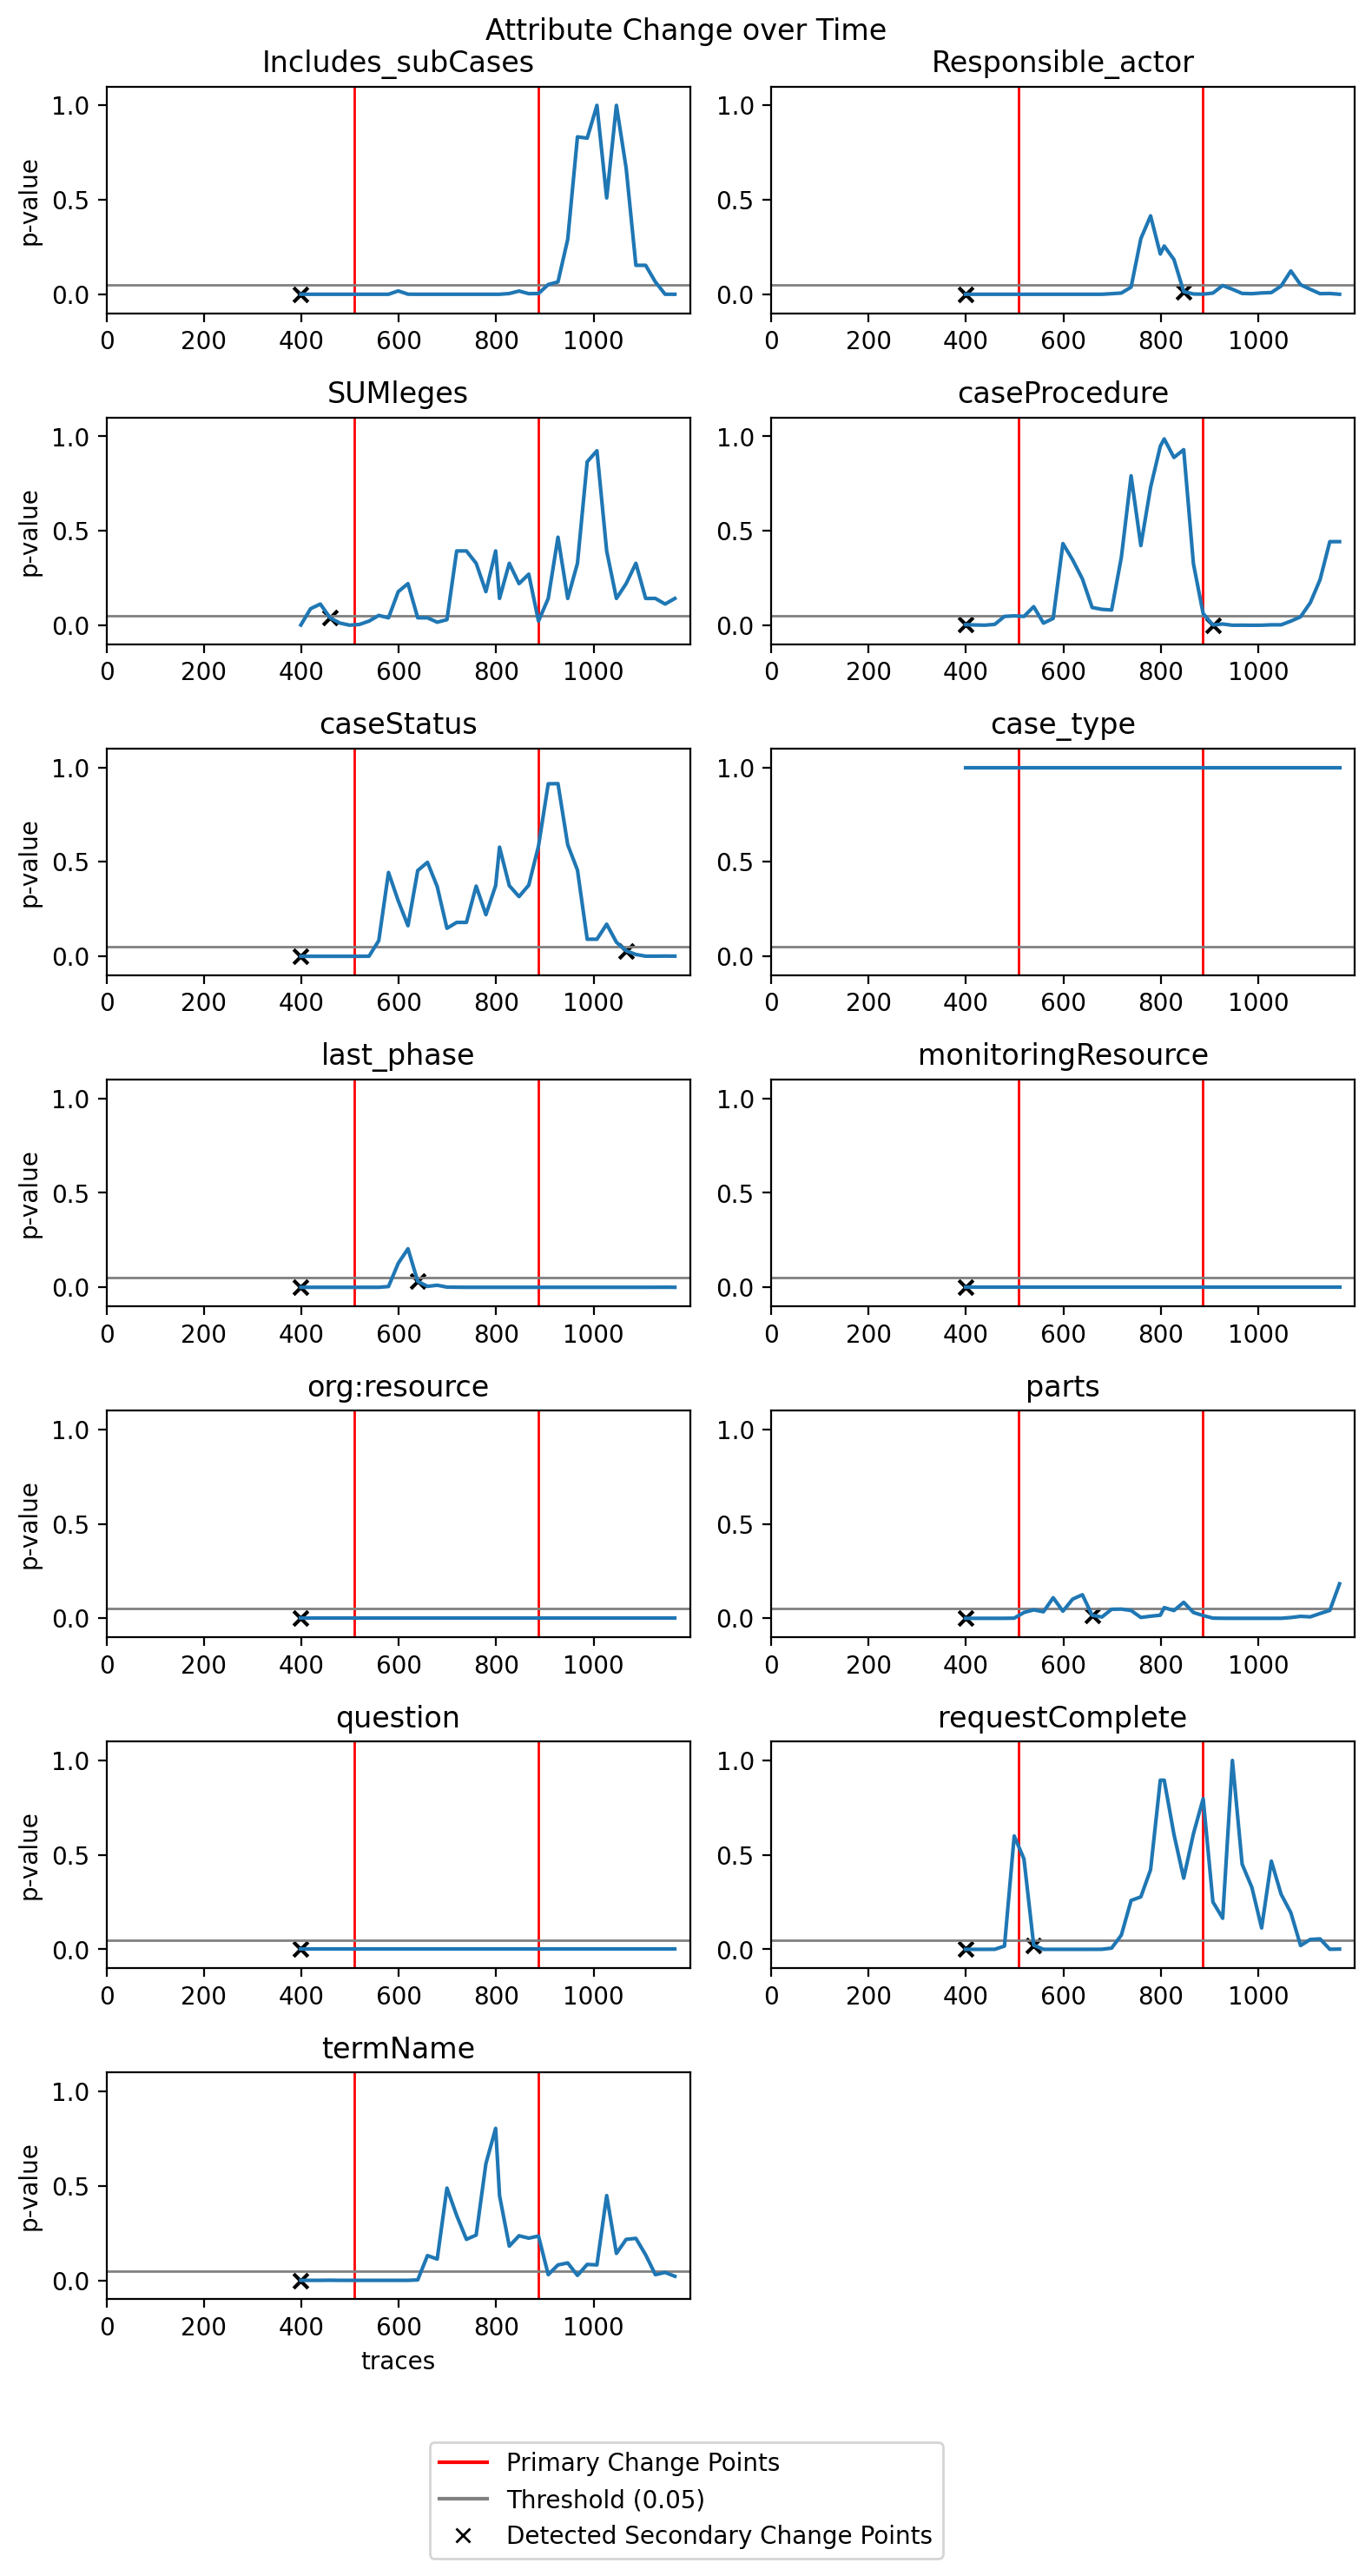

In [25]:
# plot the change point explanations for municipal 1
changes_per_mun['mun_1'].plot(offset_legend=-0.07)
pass

For municipal 1, most attribute's p-values are continuously very low (below the threshold) so that it is hard to make sense of the secondary change detectors. A less sensitive detection method, e.g., a distance measure such as Hellinger's Distance would be desired.

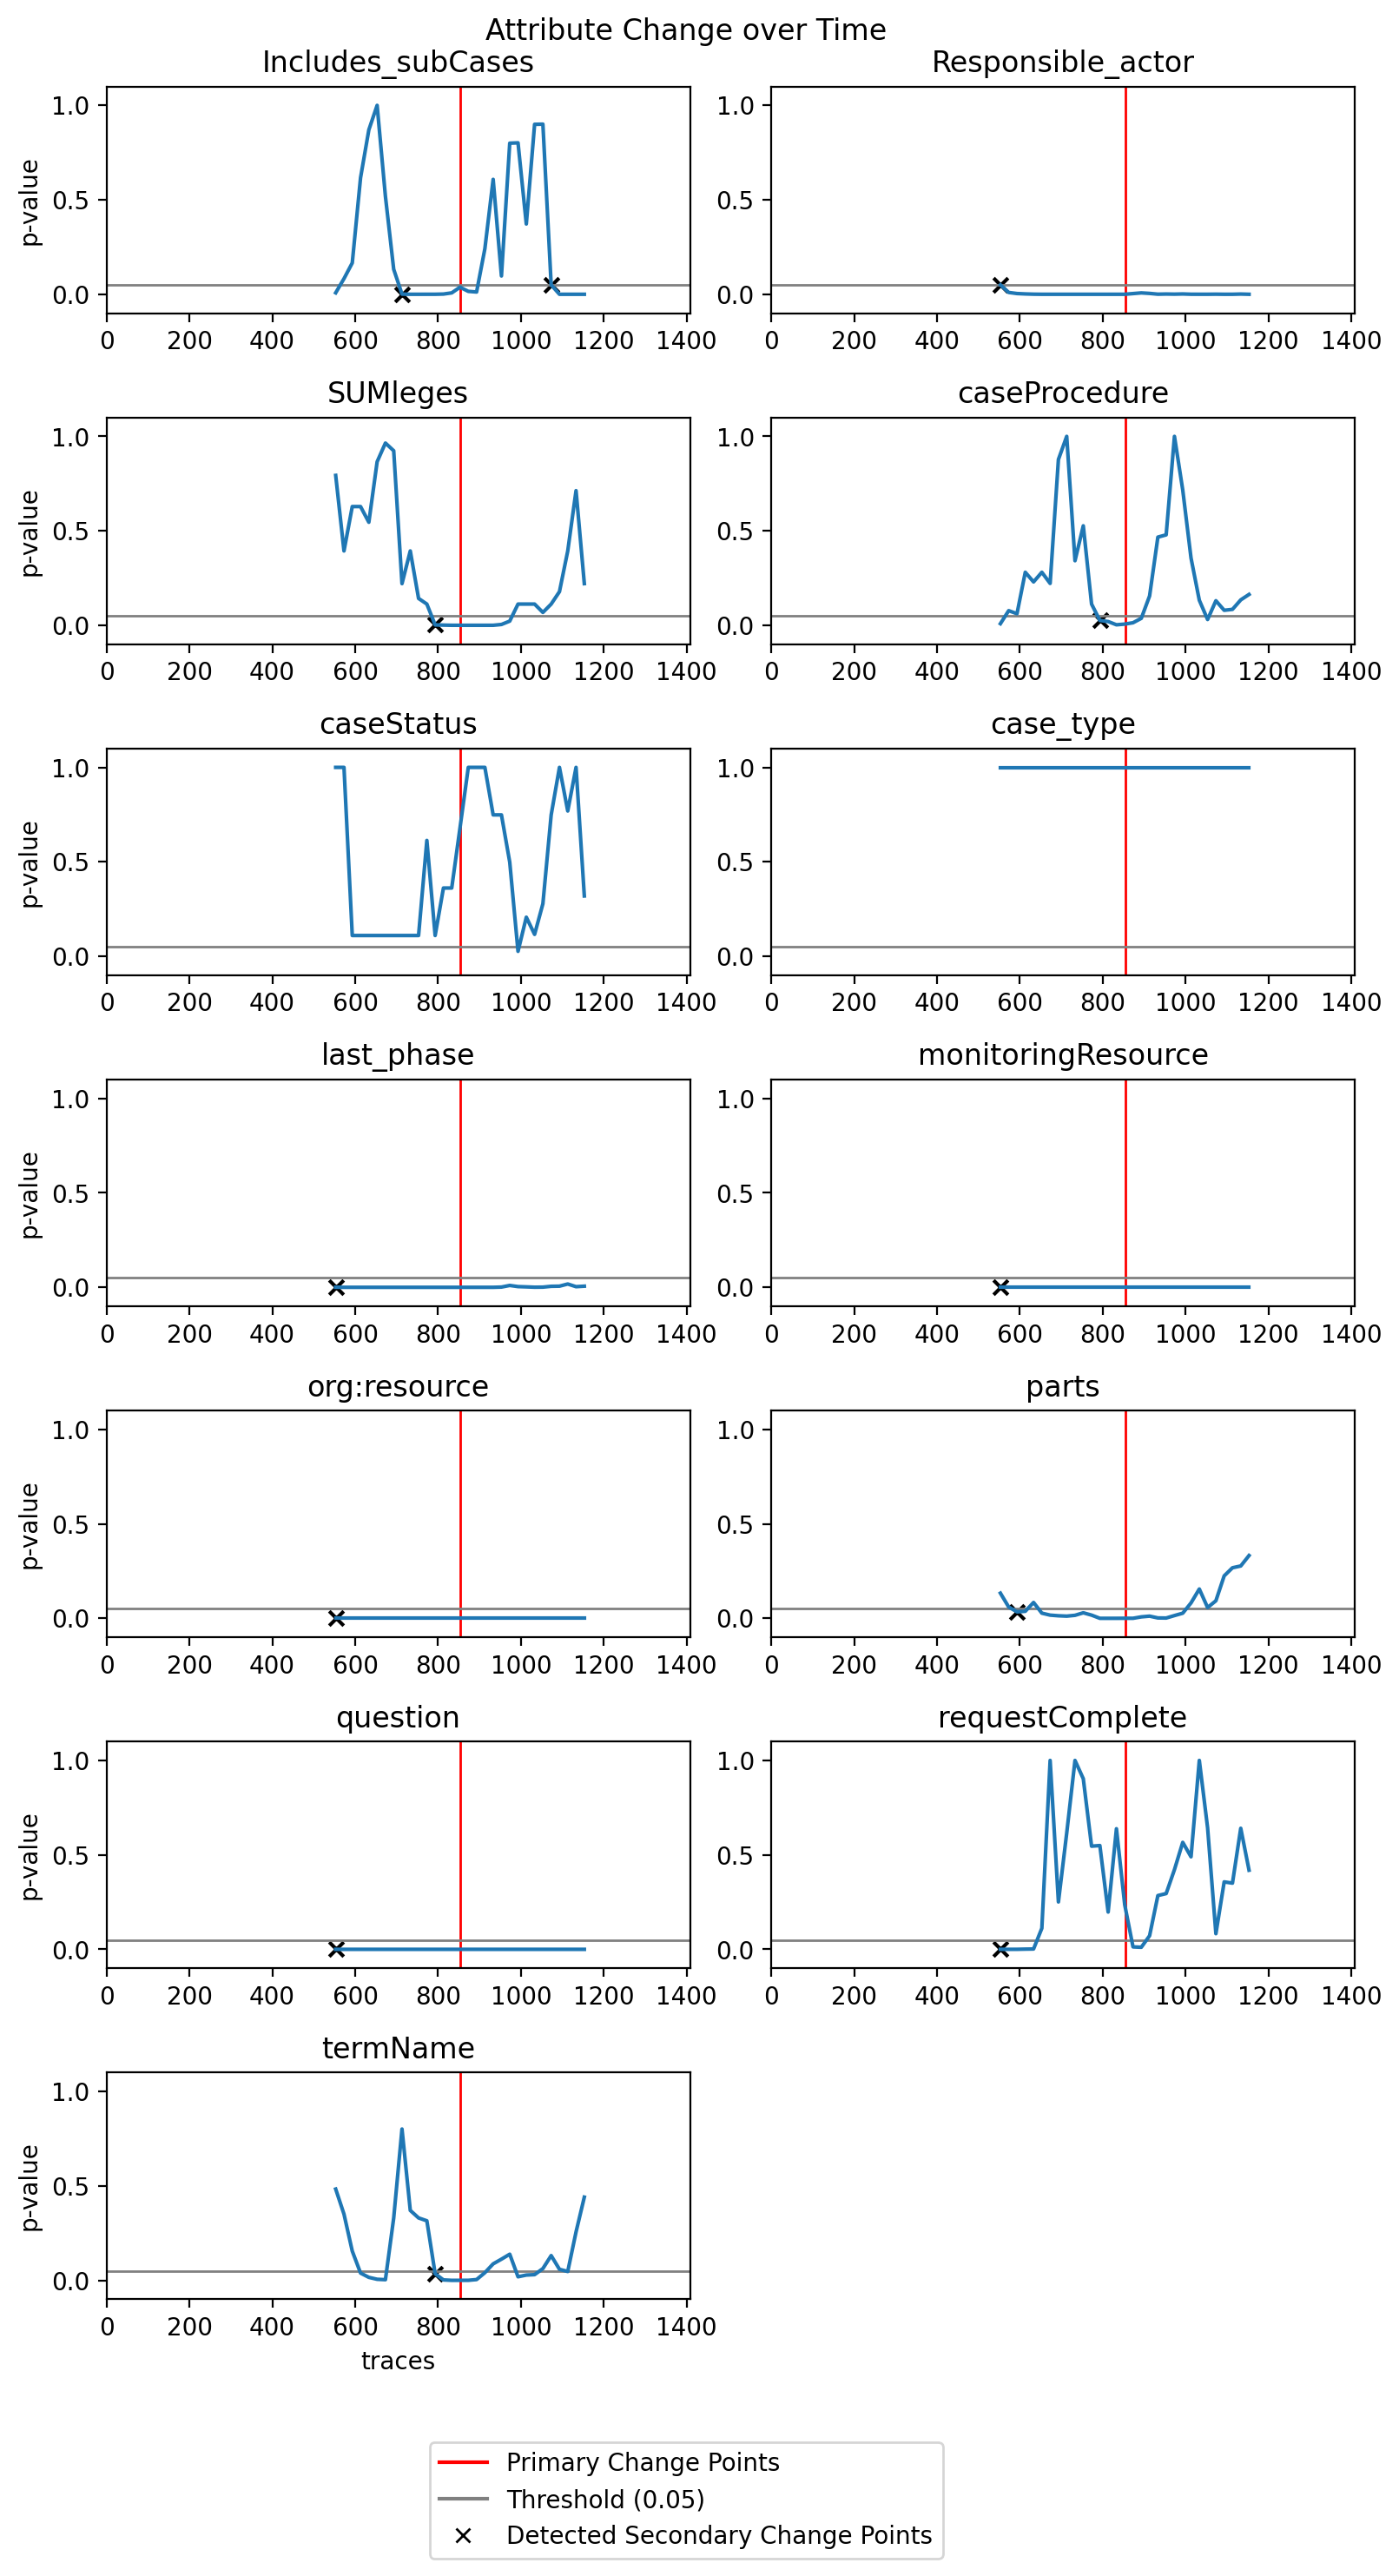

In [29]:
# plot the change point explanations for municipal 2
changes_per_mun['mun_3'].plot(offset_legend=-0.07)
pass

For municipal 3, the situation is comparable to that of municipal 1 - the change detectors are very sensitive and many are continuously below the threshold. However, visual analysis shows that the attributes 'case procedure', 'Includes_subCases', 'SUMleges' and 'request complete' show temporary drops in p-value close to the primary change point. Therefore, these attributes will be considered further in later analysis.

## Rerun the Secondary Drift Detection with another Population Comparison that is less sensitive (Hellinger's Distance)

In [48]:
for secondary_drift_detector in secondary_drift_detectors:
    secondary_drift_detector.population_comparer = population_comparison.HellingerDistancePC()

hellinger_distance_explanations = {}
for mun in ['mun_1', 'mun_3']:
    primary_change_points = changes_per_mun[mun].primary_dd_result.change_points
    primary_drift_detector = drift_detection.TrueKnownDD(primary_change_points)

    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
    hellinger_distance_explanations[mun] = changes

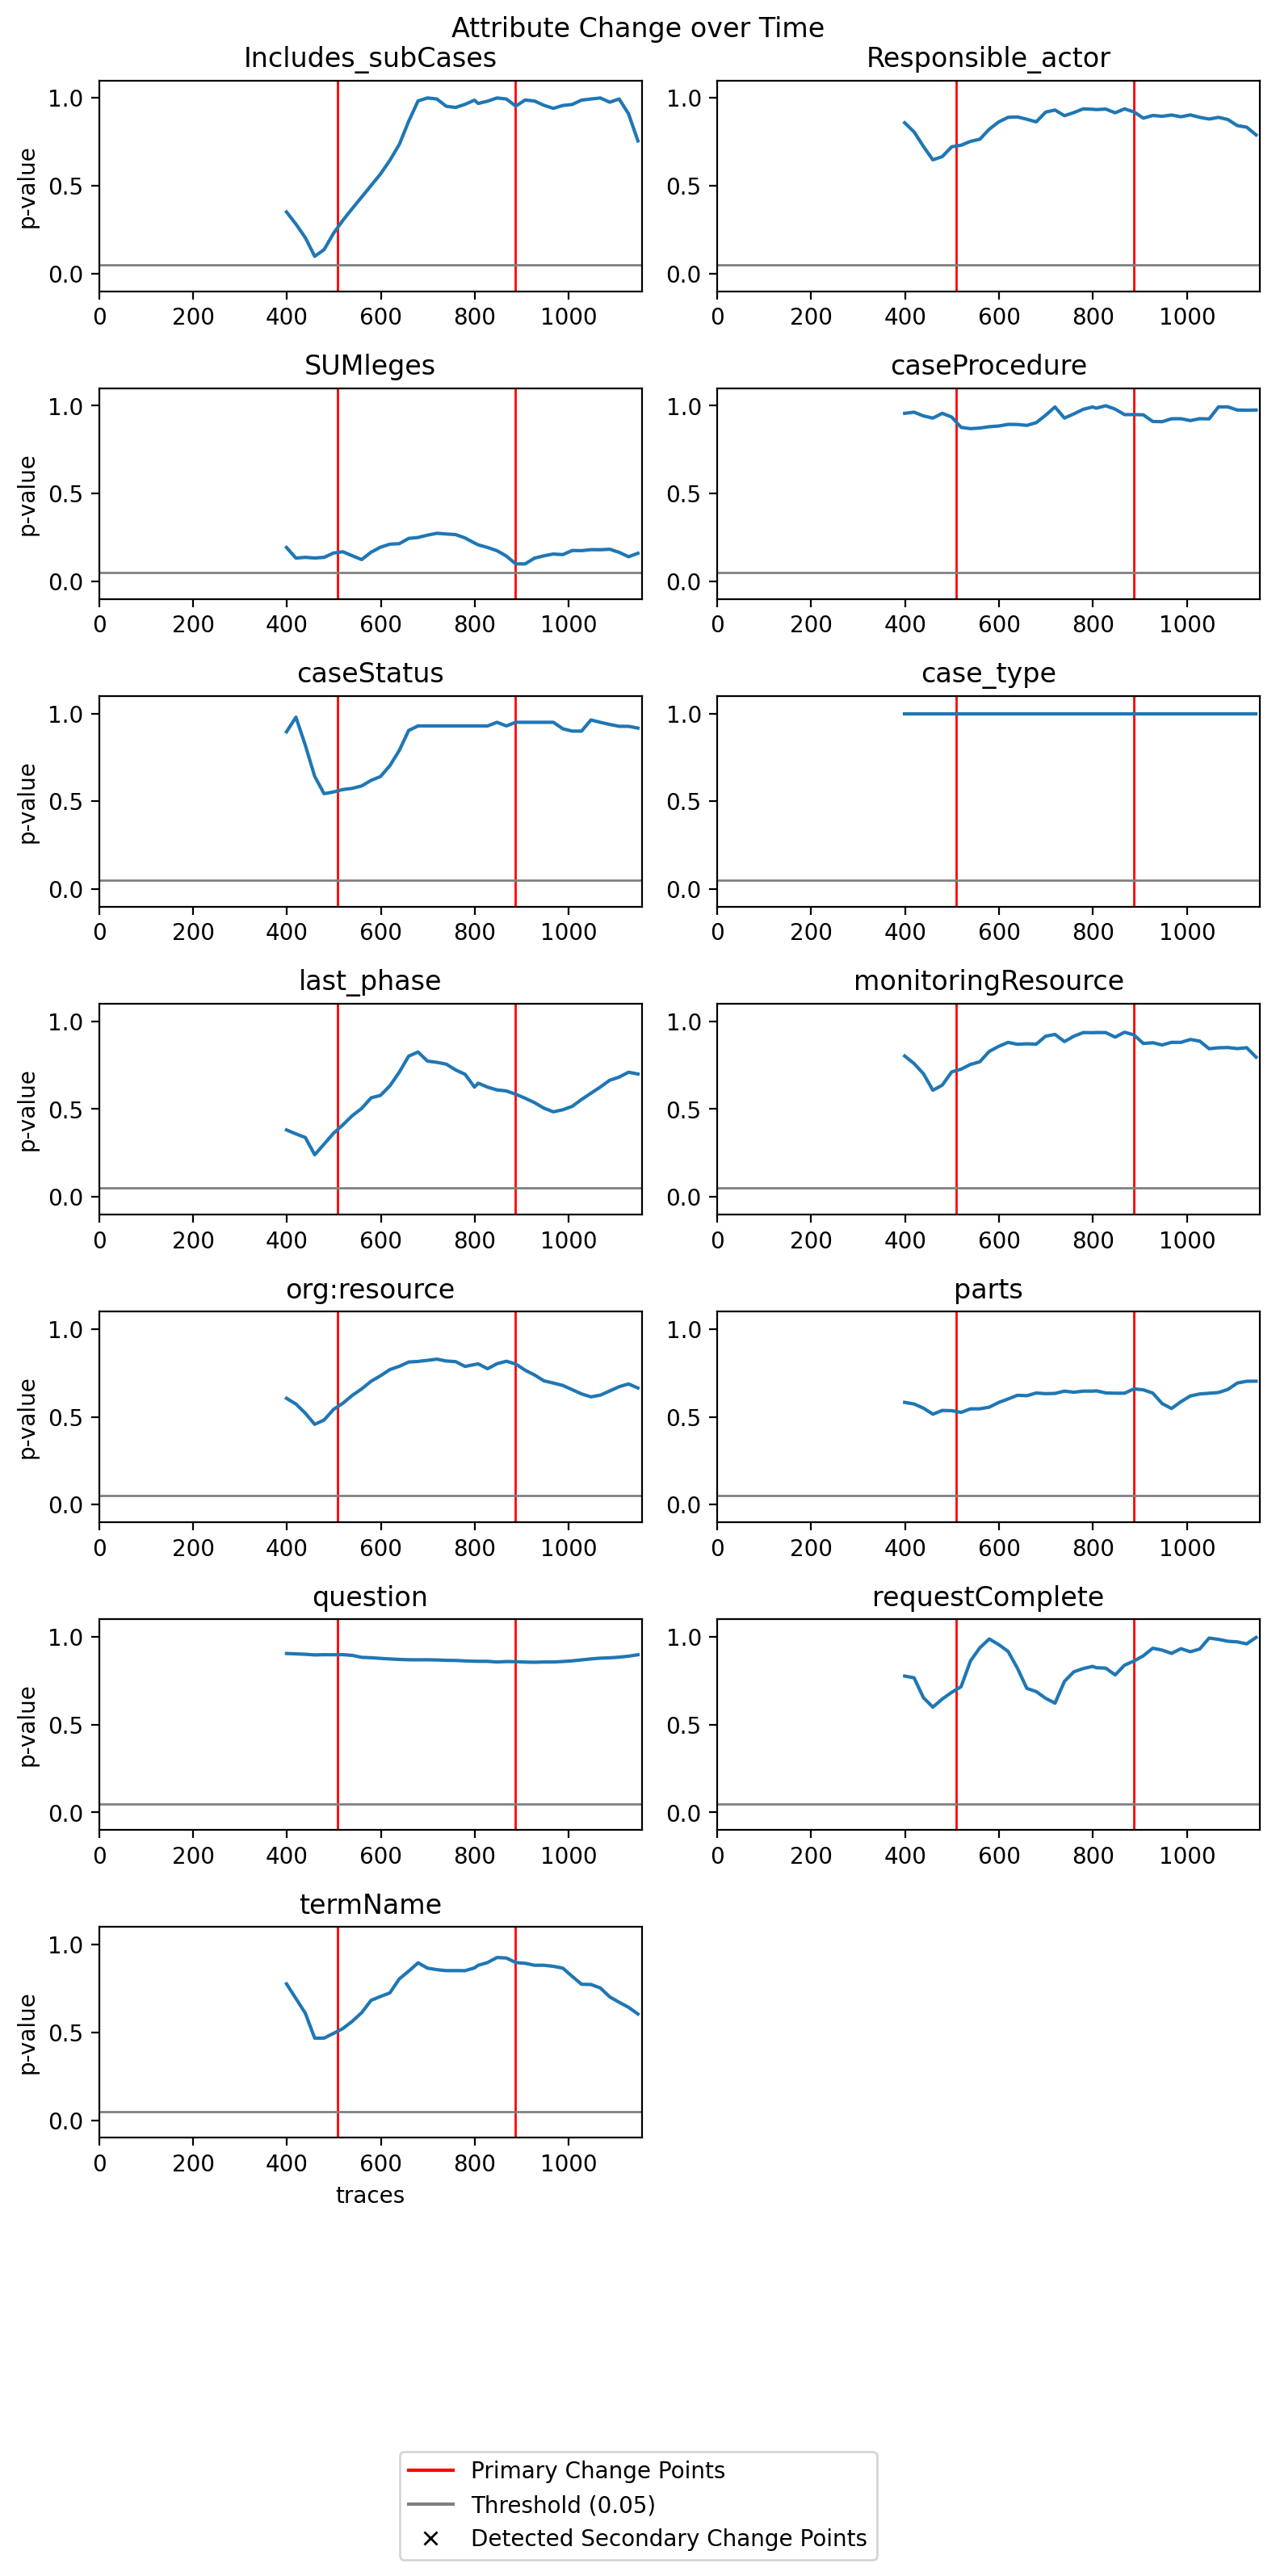

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [49]:
hellinger_distance_explanations['mun_1'].plot(ylabel='Hellinger\'s Distance', offset_legend=-0.07)
pass

'Includes_subCases' shows a strong drop in similarity measure right before the first change point. This feature should be investigated further. The same goes for 'caseStatus'.
'last_phase' has a drop before the first change point and right after the second. The curve of 'last_phase' mirrors that of 'org:resource'.
'termName' also has a drop in Hellinger's distance before the change point.

In [58]:
# Analysis for feature 'Includes_subCases'
# compare two windows with this feature
window_generator = windowing.FixedWG(200, window_offset=400, slide_by=1)
window_a, window_b = next(window_generator.get_windows(event_log, start=0, end=1000))

feature_extractor = feature_extraction.AttributeFE(attribute_level='trace', attribute_name='')

0

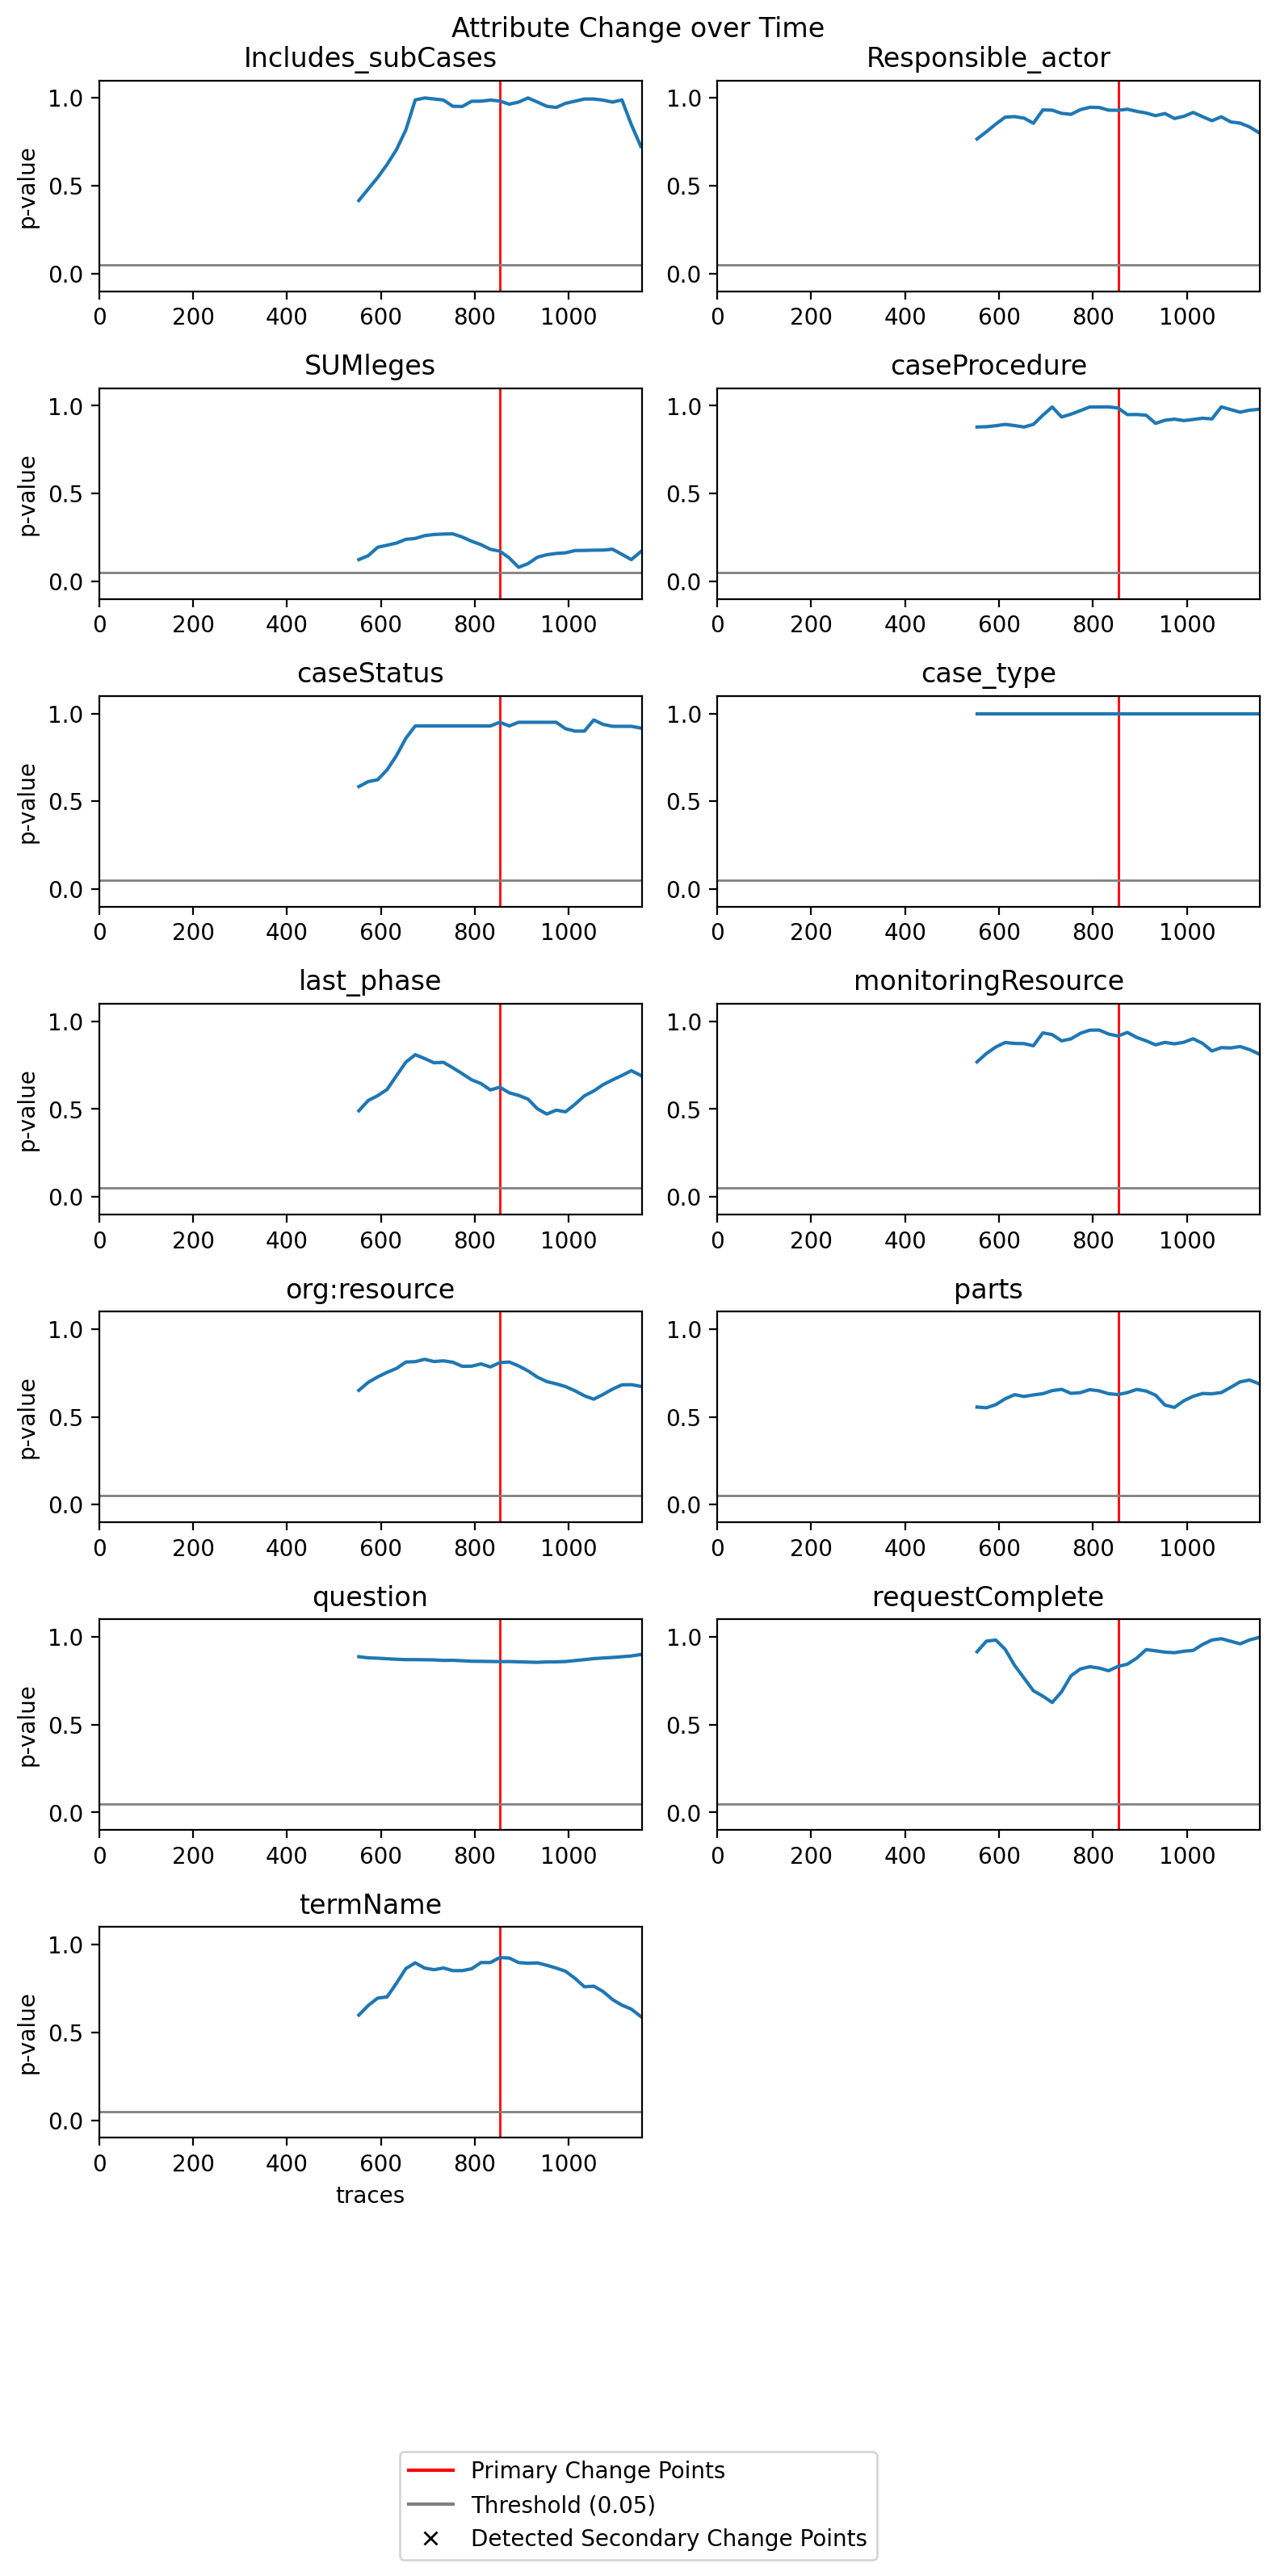

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [50]:
hellinger_distance_explanations['mun_3'].plot(ylabel='Hellinger\'s Distance', offset_legend=-0.07)
pass